1.1. Load NETCDF Files with xarray

In [ ]:
#!connect jupyter --kernel-name phd-python --conda-env phd --kernel-spec python3

The `#!connect jupyter` feature is in preview. Please report any feedback or issues at https://github.com/dotnet/interactive/issues/new/choose.

Kernel added: #!phd-python

In [ ]:
import xarray as xr
import matplotlib.animation as animation
import xarray as xr
import os
import cftime
import matplotlib.pyplot as plt
from IPython.display import HTML
import cartopy.crs as ccrs
from matplotlib.gridspec import GridSpec

In [ ]:
def load_netcdf(filepath, use_cftime=True):
    """
    Load a NETCDF file and return it as an xarray dataset.

    Parameters:
    filepath (str): Path to the NETCDF file to be loaded.
    use_cftime (bool): Whether to use cftime for handling dates out of numpy range. Default is True.

    Returns:
    xarray.Dataset: The loaded dataset.
    """
    try:
        dataset = xr.open_dataset(filepath, engine='netcdf4', use_cftime=use_cftime)
        return dataset
    except FileNotFoundError:
        print(f"Error: The file at '{filepath}' was not found.")
    except ImportError:
        print("Error: Required dependencies for reading NETCDF files are not installed. Please refer to https://docs.xarray.dev/en/stable/getting-started-guide/installing.html")
    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage:
# ds = load_netcdf('path/to/netcdf_file.nc')
# print(ds)

def assemble_datacube(folderpath, max_files=100):
    """
    Assemble a datacube along the time dimension from multiple NETCDF files in a folder until a certain maximum number of files is reached.

    Parameters:
    folderpath (str): Path to the folder containing NETCDF files.
    max_files (int, optional): The maximum number of NETCDF files to read for the assembled datacube. Default is 100.

    Returns:
    xarray.Dataset: The assembled datacube.
    """
    
    def convert_360_to_180(values):
        return xr.where(values < 180, values, values - 360)

    datasets = []
    file_count = 0

    try:
        for filename in os.listdir(folderpath):
            if filename.endswith(".nc"):
                filepath = os.path.join(folderpath, filename)
                ds = load_netcdf(filepath)
                if ds is not None:
                    datasets.append(ds)
                    file_count += 1
                    if file_count >= max_files:
                        break

        if datasets:
            datacube = xr.concat(datasets, dim='time')
            datacube['lon'] = convert_360_to_180(datacube['lon'])
            datacube = datacube.sortby(['lat', 'lon'])
            return datacube
        else:
            print("No valid NETCDF files found in the folder.")
    except Exception as e:
        print(f"An error occurred while assembling the datacube: {e}")

# Example usage:
# datacube = assemble_datacube('path/to/folder')
# print(datacube)

CMISP_FULL = assemble_datacube(folderpath=r"c:\ThesisData\CMISP",max_files=5)
CMISP_FULL

<xarray.Dataset>
Dimensions:    (time: 1826, bnds: 2, lat: 256, lon: 512)
Coordinates:
  * time       (time) object 2259-01-01 12:00:00 ... 2263-12-31 12:00:00
  * lat        (lat) float64 -89.46 -88.77 -88.07 -87.37 ... 88.07 88.77 89.46
  * lon        (lon) float64 -180.0 -179.3 -178.6 -177.9 ... 177.9 178.6 179.3
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 2259-01-01 00:00:00 ... 2264-01-01 00:00:00
    lat_bnds   (time, lat, bnds) float64 -90.0 -89.11 -89.11 ... 89.11 90.0
    lon_bnds   (time, lon, bnds) float64 179.6 180.4 180.4 ... 178.9 178.9 179.6
    pr         (time, lat, lon) float32 5.519e-09 6.101e-09 ... 6.013e-08
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time:            0.0
    comment:                Production: Thomas Reerink at KNMI
    contact:                cmip6-data@ec-earth.org
    ...                     ...
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/5437b8d7-234f-4233-9c25-76053f5ec11f
    branch_time_in_parent:  0.0D
    parent_experiment_id:   piControl
    branch_time_in_child:   149384.0D
    history:                2019-07-11T19:27:51Z ; CMOR rewrote data to be co...

In [ ]:
def mask_cuboidPoints_square(ds, center, side_length):
    """
    Masks the dataset to include only points within a specified square.

    Parameters:
    ds (xarray.Dataset): The xarray dataset containing latitude and longitude data.
    center (tuple): A tuple of coordinates (longitude, latitude) representing the center of the square.
    side_length (float): The side length of the square in degrees.

    Returns:
    xarray.Dataset: A new xarray dataset containing only the points within the specified square.
    """

    ds = ds.copy()
    # Calculate the half side length
    half_side = side_length / 2

    # Define the boundaries of the square
    min_lon = center[0] - side_length
    max_lon = center[0] + side_length
    min_lat = center[1] - side_length
    max_lat = center[1] + side_length

    # Apply the mask to select points within the square
    masked_ds = ds.where(
        ((ds['lon'] >= min_lon) & (ds['lon'] <= max_lon) &
        (ds['lat'] >= min_lat) & (ds['lat'] <= max_lat)),drop = True
    )
    return masked_ds.dropna(dim='lat', how='all').dropna(dim='lon')
# Example usage:
# datacube = assemble_datacube('path/to/folder')
# anim = animate_datacube(datacube, time_range=10)
# anim

center_coordinates = (4.4699, 50.5039)  # Center around Europe (longitude, latitude)
side_length = 5  # Side length of the square in degrees
CMISP_europe = mask_cuboidPoints_square(CMISP_FULL, center_coordinates, side_length)

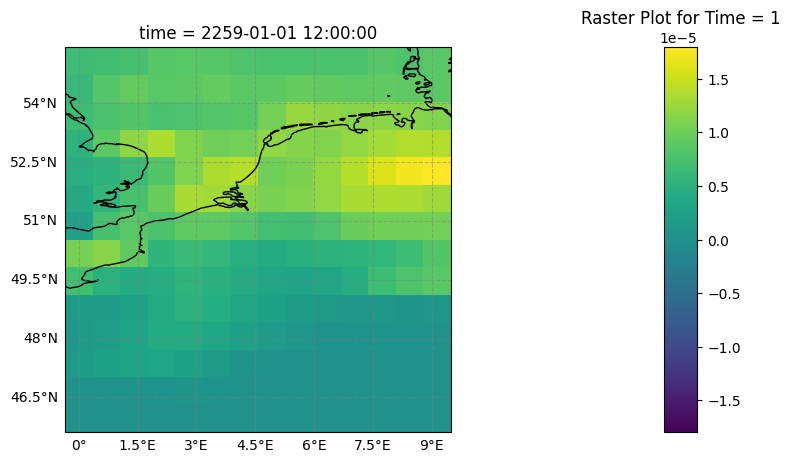

In [ ]:
def plot_datacube(ds, time_step=0, ax=None, cbar_ax=None, fig=None):
    """
    Plot a single time step of the datacube.

    Parameters:
    ds (xarray.Dataset): The dataset containing the data to be plotted.
    time_step (int, optional): The time step to plot. Default is 0.
    ax (matplotlib.axes._subplots.AxesSubplot, optional): Axis to plot on. Default is None.
    cbar_ax (matplotlib.axes._subplots.AxesSubplot, optional): Axis for the colorbar. Default is None.
    fig (matplotlib.figure.Figure, optional): Figure object for adding the colorbar. Default is None.
    """
    if ax is None or cbar_ax is None or fig is None:
        gs = GridSpec(1, 2, width_ratios=[1, 0.05])
        fig = plt.figure(figsize=(10, 5))
        ax = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())
        cbar_ax = fig.add_subplot(gs[1])

    data = ds['pr'].isel(time=time_step)
    img = data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis', add_colorbar=False)
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}
    plt.title(f'Raster Plot for Time = {time_step + 1}')
    fig.colorbar(img, cax=cbar_ax, shrink=0.5, aspect=5)
    if ax is None or cbar_ax is None or fig is None:
        plt.show()


plot_datacube(CMISP_europe)

In [ ]:
CMISP_FULL

<xarray.Dataset>
Dimensions:    (time: 1826, bnds: 2, lat: 256, lon: 512)
Coordinates:
  * time       (time) object 2259-01-01 12:00:00 ... 2263-12-31 12:00:00
  * lat        (lat) float64 -89.46 -88.77 -88.07 -87.37 ... 88.07 88.77 89.46
  * lon        (lon) float64 -180.0 -179.3 -178.6 -177.9 ... 177.9 178.6 179.3
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 2259-01-01 00:00:00 ... 2264-01-01 00:00:00
    lat_bnds   (time, lat, bnds) float64 -90.0 -89.11 -89.11 ... 89.11 90.0
    lon_bnds   (time, lon, bnds) float64 179.6 180.4 180.4 ... 178.9 178.9 179.6
    pr         (time, lat, lon) float32 5.519e-09 6.101e-09 ... 6.013e-08
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time:            0.0
    comment:                Production: Thomas Reerink at KNMI
    contact:                cmip6-data@ec-earth.org
    ...                     ...
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/5437b8d7-234f-4233-9c25-76053f5ec11f
    branch_time_in_parent:  0.0D
    parent_experiment_id:   piControl
    branch_time_in_child:   149384.0D
    history:                2019-07-11T19:27:51Z ; CMOR rewrote data to be co...

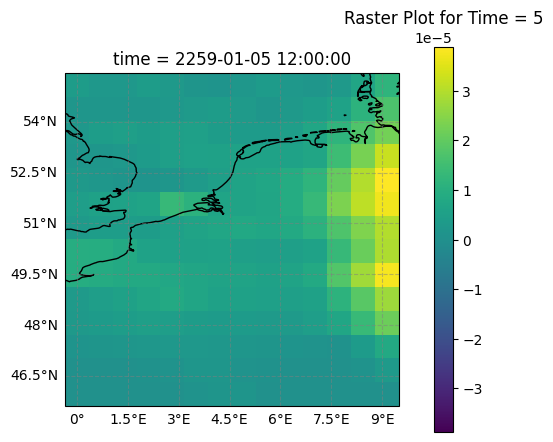

In [ ]:
def animate_datacube(ds, time_range=10):
    """
    Create an animation of the datacube over the time dimension.

    Parameters:
    ds (xarray.Dataset): The dataset containing the data to be animated.
    time_range (int, optional): The number of time steps to animate. Default is 10.
    """
    gs = GridSpec(1, 2, width_ratios=[0.9, 0.05])
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())
    cbar_ax = fig.add_subplot(gs[1])

    def update(frame):
        ax.clear()
        plot_datacube(ds, frame, ax=ax, cbar_ax=cbar_ax, fig=fig)

    ani = animation.FuncAnimation(fig, update, frames=time_range, interval=500)
    plt.rcParams['animation.embed_limit'] = 50  # Set embed limit to 50 MB
    return HTML(ani.to_jshtml())

# Example usage:
# datacube = assemble_datacube('path/to/folder')
# anim = animate_datacube(datacube, time_range=10)
# anim

animate_datacube(CMISP_europe, time_range=5)